In [1]:
import numpy as np
import matplotlib.pyplot as plt             
import seaborn as sns    
from simulation.constants import *
from simulation.utils import apply_PBC, build_neighbor_list
from simulation.forces import total_force
from simulation.thermostat import rescaleT
from simulation.io import dump, radius_of_gyration, mean_squared_displacement

In [2]:
# Initialization of Positions, Velocities, and Topology
mu = L[0] / 2  # Center of the box
sigma = 0.1 * L[0]  # Standard deviation (adjust as needed)

r = np.random.normal(mu, sigma, size=(n, D))   # Random initial positions within box
v = np.random.randn(n, D)                      # Random initial velocities from normal distribution

tp, mols, bnd, angs = [], [], [], []           # Lists for types, molecule ids, bonds, and angles

# Create chains with bonds and angles
for c in range(n_chains):
    base = c * n_monomers                      # Index of first monomer in this chain
    mon_type = 0 if c < n_PE_chains else 1     # PE or PS type
    for i in range(n_monomers):
        tp.append(mon_type)                    # Monomer type
        mols.append(c)                         # Chain id
        if i < n_monomers - 1:
            bnd.append([base + i, base + i + 1, bond_length, K_bond])
        if 0 < i < n_monomers - 1:
            th0, Kth = angle_params[mon_type]
            angs.append([base + i - 1, base + i, base + i + 1, th0, Kth])

# Convert lists to NumPy arrays
tp = np.array(tp)
mols = np.array(mols)
mm = np.array([mass_types[t] for t in tp])     # Masses assigned by type
bnd = np.array(bnd)                            # Bond list
angs = np.array(angs)                          # Angle list

In [3]:
# Main Simulation Loop

# ---- Initialization ----
neighbor_list = build_neighbor_list(r)                               # Build initial neighbor list
r0_msd = r.copy()                                                    # Save initial positions for MSD calculation
a = total_force(tp, bnd, angs, r, neighbor_list) / mm[:, None]       # Compute initial accelerations
STEPS = 30000                                                        # Total number of time steps
dump_interval = 100                                                  # How often to record data (every 100 steps)

# ---- Data Containers ----
Rg_over_time = []         # Mean radius of gyration at each dump step
Rg_std_over_time = []     # Standard deviation of Rg (across chains) at each dump step
MSD_over_time = []        # Mean squared displacement at each dump step

# ---- Time Integration ----
for step in range(STEPS):
    # Velocity Verlet Step 1: update velocity half-step and position
    v += 0.5 * a * dt
    r += v * dt
    r = apply_PBC(r)                                  # Apply periodic boundary conditions

    # Update neighbor list periodically to save computation
    if step % neighbor_update_interval == 0:
        neighbor_list = build_neighbor_list(r)

    # Velocity Verlet Step 2: update acceleration and velocity
    a_new = total_force(tp, bnd, angs, r, neighbor_list) / mm[:, None]
    v += 0.5 * a_new * dt
    a = a_new

    # Optional thermostat: rescale temperature to maintain target T0
    v = rescaleT(v, mm, T0)

    # ---- Data Dumping ----
    if step % dump_interval == 0:
        frame = step // dump_interval                 # Current saved frame index
        dump(r, mols, tp, frame)                                # Save coordinates

        # Compute radius of gyration per chain and its stats
        Rg = radius_of_gyration(r, mols)
        Rg_mean = np.mean(Rg)
        Rg_std = np.std(Rg)

        # (Optional for legacy MSD approach) compute MSD from initial positions
        MSD = mean_squared_displacement(r, r0_msd)

        # Store current measurements
        Rg_over_time.append(Rg_mean)
        Rg_std_over_time.append(Rg_std)
        MSD_over_time.append(MSD)

        # Print progress
        print(
            f"Step {step:6} | Frame {frame:4} | "
            f"<Rg> = {Rg_mean:.3f} ± {Rg_std:.3f} | MSD = {MSD:.3f}"
        )

Step      0 | Frame    0 | <Rg> = 9.363 ± 0.573 | MSD = 65.257
Step    100 | Frame    1 | <Rg> = 9.964 ± 0.576 | MSD = 78.920
Step    200 | Frame    2 | <Rg> = 9.850 ± 0.540 | MSD = 77.667
Step    300 | Frame    3 | <Rg> = 9.755 ± 0.525 | MSD = 77.169
Step    400 | Frame    4 | <Rg> = 9.674 ± 0.523 | MSD = 77.268
Step    500 | Frame    5 | <Rg> = 9.630 ± 0.557 | MSD = 77.449
Step    600 | Frame    6 | <Rg> = 9.608 ± 0.609 | MSD = 77.749
Step    700 | Frame    7 | <Rg> = 9.589 ± 0.672 | MSD = 77.923
Step    800 | Frame    8 | <Rg> = 9.549 ± 0.714 | MSD = 78.220
Step    900 | Frame    9 | <Rg> = 9.520 ± 0.765 | MSD = 78.583
Step   1000 | Frame   10 | <Rg> = 9.507 ± 0.839 | MSD = 79.037
Step   1100 | Frame   11 | <Rg> = 9.480 ± 0.898 | MSD = 79.594
Step   1200 | Frame   12 | <Rg> = 9.473 ± 0.972 | MSD = 80.048
Step   1300 | Frame   13 | <Rg> = 9.448 ± 1.022 | MSD = 80.538
Step   1400 | Frame   14 | <Rg> = 9.427 ± 1.069 | MSD = 81.052
Step   1500 | Frame   15 | <Rg> = 9.391 ± 1.097 | MSD =

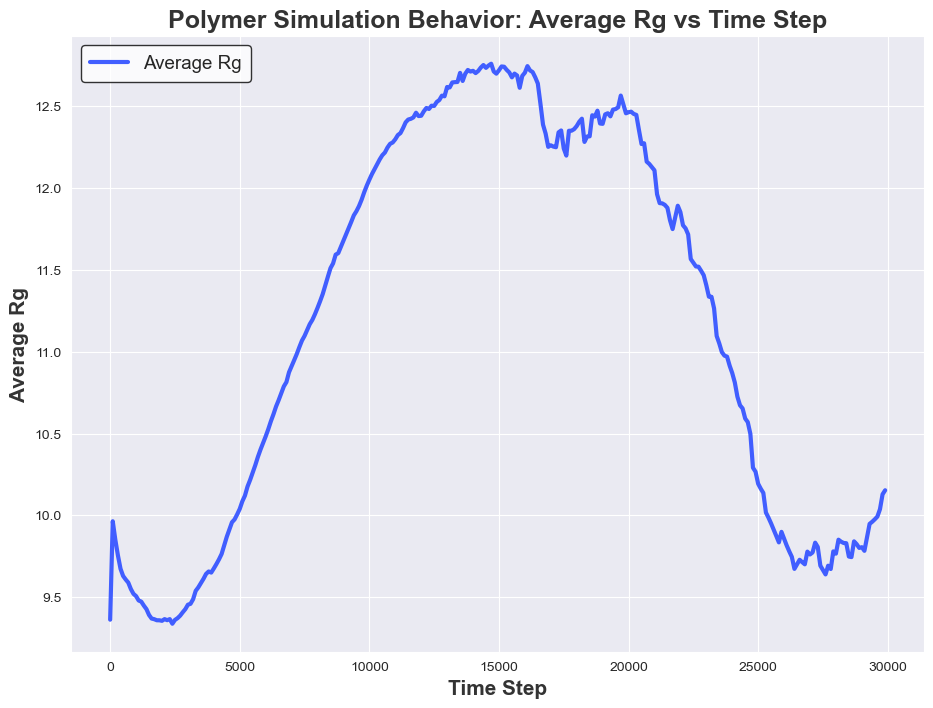

In [4]:
Rg_over_time = np.array(Rg_over_time)  # Convert to a NumPy array if it's not already

# Set plot style
sns.set_style('darkgrid')
sns.set_palette("crest")

# Create a figure for plotting
plt.figure(figsize=(11, 8))

# Plot the average Rg over time
plt.plot(np.arange(0, STEPS, dump_interval), Rg_over_time, label="Average Rg", color="#415eff", lw=3, markersize=8)

# Title and labels
plt.title('Polymer Simulation Behavior: Average Rg vs Time Step', fontsize=18, fontweight='bold', color='#333333')
plt.xlabel('Time Step', fontsize=15, fontweight='bold', color='#333333')
plt.ylabel('Average Rg', fontsize=15, fontweight='bold', color='#333333')

# Add grid and legend
plt.grid(True)
plt.legend(loc="upper left", fontsize=13.5, frameon=True, edgecolor="black", facecolor="white", borderpad=0.5)

# Display the plot
plt.show()